# Object Detection for Visually Impaired

## Import

The below are the required packages to be installed on anaconda.

In [2]:
#Packages to be installed
! pip install ultralytics
! pip install pycocotools
! pip install wandb
! pip install optuna

     ---------------------------------------- 6.7/6.7 MB 13.8 MB/s eta 0:00:00
     -------------------------------------- 303.6/303.6 kB 9.5 MB/s eta 0:00:00
     ------------------------------------- 207.3/207.3 kB 12.3 MB/s eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB 3.3 MB/s eta 0:00:00


All the necessary libraries are imported.

In [1]:
#Import required libraries
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import wandb

%matplotlib inline

## Image and label directory

We set the directories for the train, valid and test directories for the images and the labels. Change the path to were the images are stored

In [3]:
#Set the directories for images and labels
root_dir=r"C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull"
train_imgs_dir=r"C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\train\images"
valid_imgs_dir=r"C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\valid\images"
test_imgs_dir=r"C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images"

train_labels_dir=r"C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\train\labels"
valid_labels_dir=r"C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\valid\labels"
test_labels_dir=r"C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\labels"

## Bounding boxes

The classes in the dataset are created in a dictionary and the keys are their index value.

In [4]:
#Dictionary of classes for the datset
names={0:"aeroplane",1:"bicycle",2:"bird",3:"boat",4:"bottle",5:"bus",
       6:"car",7:"cat",8:"chair",9:"cow",10:"diningtable",11:"dog",12:"horse",
      13:"motorbike",14:"person",15:"pottedplant",16:"sheep",17:"sofa",18:"train",19:"tvmonitor"}
COLORS=np.random.uniform(0,255,(20,3))

The code to read the label files and plot the bounding boxes are shown below.

In [5]:
#Drawing the bounding boxes
def show_bbox(img_name,img_dir,label_dir,axis):
    img_path=os.path.join(img_dir,img_name)
    img=cv2.imread(img_path)
    print(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h,w,_=img.shape
    img=img.copy()
    
    try:
        label_path=os.path.join(label_dir,img_name[:-4]+".txt")
        label=pd.read_csv(label_path,sep=" ",header=None).values
        classes=label[:,0]
        boxes=label[:,1:]
        for i,box in enumerate(boxes):
            cls_id=int(classes[i])
            text=names[cls_id]
            color=COLORS[cls_id]
            xmin=int((box[0]-box[2]/2)*w)
            ymin=int((box[1]-box[3]/2)*h)
            xmax=int((box[0]+box[2]/2)*w)
            ymax=int((box[1]+box[3]/2)*h)
            cv2.rectangle(img,(xmin,ymin),(xmax,ymax),color,3)
            y=ymin-10 if ymin-10>10 else ymin+20
            cv2.putText(img,text,(xmin,y),cv2.FONT_HERSHEY_SIMPLEX,1.5,color,3)
    except:
        pass
    
    axis.imshow(img)
    axis.axis("off")

Random images are selected and the bounding boxes are drawn to show an example.

C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\train\images\008596_jpg.rf.d2b047dc629d98c4e5c57f345ed84447.jpg
C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\train\images\003088_jpg.rf.7b723b7af9d194270f3f442ab500b7c6.jpg
C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\train\images\003419_jpg.rf.1c82e064983c426d7b9efaf65e3a46cc.jpg
C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\train\images\005223_jpg.rf.a5637236d42e50099103568daf2afd63.jpg
C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\train\images\003218_jpg.rf.729bbbfc330966acb1bb58733996c821.jpg
C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\train\images\000209_jpg.rf.74aa92bf08ee5949c97e31002c7d0867.jpg
C:\Users\jarus\D

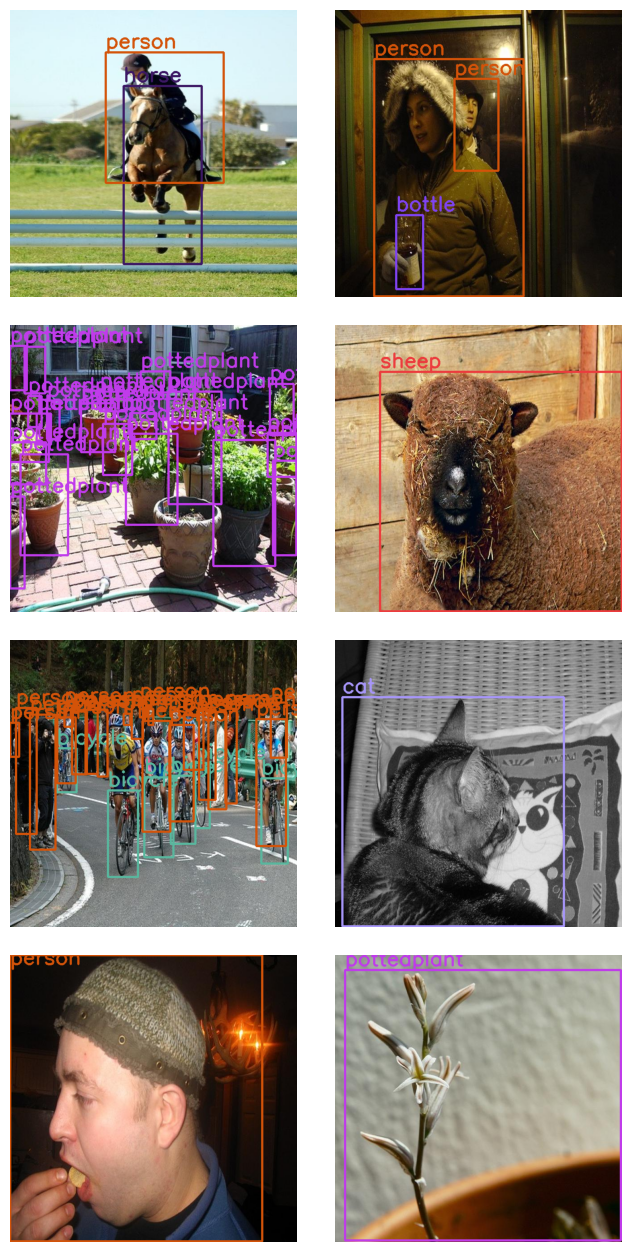

In [6]:
#Select 8 random images and show bounding boxes
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()


train_img_list=sorted(os.listdir(train_imgs_dir))
img_name_list=np.random.choice(train_img_list,8)


for i,img_name in enumerate(img_name_list):
    show_bbox(img_name,train_imgs_dir,train_labels_dir,ax[i])
    
plt.savefig("1.png")

## YOLO

The YOLO yaml file is created with the directories of the images and labels, number of classes and names of the classes. Save the yaml file in the required directory.

In [7]:
#Create yolo yaml file
yolo_format=dict(path=root_dir,
                 train=train_imgs_dir,
                 val=valid_imgs_dir,
                 nc=20,
                 names=names)
                 
with open('C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/yolo1.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

## Wandb

In [8]:
#Login to wandb
import wandb
api_key = 'b990db0090a364f4565b33a679ce67096185ebe2'
wandb.login(key=api_key)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: suraj-bodhan (suraj-bodhan-university-college-dublin). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\jarus\.netrc


True

## Training

The model yolov8s is used because it gives a balance between accuracy and speed. Another reason to select yolov8s is due to the hardware constraints. The yaml_path has also been set.

In [30]:
#Create yolo model object and set yaml path
import optuna
model=YOLO('yolov8s.pt')
yaml_path = "C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/yolo1.yaml"

We define an objective function for hyperparameter tuning where the model is executed multiple times with different combinations to find a suitable hyperparameter set.

In [42]:
#Create objective function for tuning purpose
#The objective is to maximise mAP
def objective(trial):
    #Hyperparameter space - more parameters can be added
    #Image size, learning rate, momentum, weight decay, anchor boxes, confidence threshold
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    img_size = trial.suggest_categorical('img_size', [320, 416, 512, 640]) # Common yolo image size
    momentum = trial.suggest_uniform('momentum', 0.85, 0.99)  # Typical range for momentum
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    
    #Train the model with the given hyperparameters
    results = model.train(
        data=yaml_path,
        epochs=10,
        batch=8,
        lr0=learning_rate,
        imgsz=img_size,
        momentum=momentum,
        weight_decay=weight_decay,
        verbose=False,
        workers=0,
        optimizer='AdamW',
        cos_lr=True,
        freeze=10
    )    
    
    #Objective to maximize: map
    map_value = results.results_dict['metrics/mAP50-95(B)']
    return map_value

It is best to clean up the memory before executing the model to avoid crashes due to lack of memory.

In [43]:
#Free up memory to avoid crashes due to lack of memory
import gc
gc.collect()
torch.cuda.empty_cache()

The model was run on a laptop with the following specifications
CPU - AMD Ryzen 7 6800HS, GPU - Nvidia RTX 3060 - 6GB VRAM, 16GB RAM.

With the above configuration, the model takes on an average 1.5 mins per epoch. The model is set for 150 epochs but since early stopping is used, it stops around 60 epochs and takes on average 2 hours to execute.

In [44]:
#Create an Optuna study object to perform hyperparameter tuning
study = optuna.create_study(direction='maximize')

#Start the hyperparameter optimization
#Model runs on 10 different hyperparameter combinations
study.optimize(objective, n_trials=10, timeout=3600)

#Get the best hyperparameters
print(f"Best trial: {study.best_trial.params}")

[I 2024-08-09 22:48:03,987] A new study created in memory with name: no-name-6d0e196d-5cff-48eb-861c-7bdf914c00fa


New https://pypi.org/project/ultralytics/8.2.75 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/yolo1.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train17, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnos

train: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\tra
val: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\valid


Plotting labels to runs\detect\train17\labels.jpg... 
optimizer: AdamW(lr=0.001439700829130455, momentum=0.9463119667656538) with parameter groups 57 weight(decay=0.0), 64 weight(decay=3.221022671383441e-06), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs\detect\train17
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.27G      1.252      2.127      1.417         10        512: 100%|██████████| 439/439 [01:06<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.569      0.525      0.557      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.33G      1.382      1.866      1.515          5        512: 100%|██████████| 439/439 [01:02<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.541      0.529      0.543       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.32G      1.378       1.77      1.526          3        512: 100%|██████████| 439/439 [01:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.578      0.543      0.567      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.34G      1.321      1.627       1.47          5        512: 100%|██████████| 439/439 [01:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.657      0.585      0.646      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.32G      1.245      1.486      1.432          2        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.674      0.626       0.67       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       2.3G      1.173      1.377      1.387          3        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.688      0.617      0.674      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.32G      1.121       1.28      1.343          3        512: 100%|██████████| 439/439 [00:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.722      0.658      0.721      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.32G       1.08      1.193      1.311          7        512: 100%|██████████| 439/439 [00:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.747      0.686       0.75        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       2.3G      1.029      1.117      1.277          6        512: 100%|██████████| 439/439 [00:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.752      0.691       0.75      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.31G       1.01      1.087      1.265          6        512: 100%|██████████| 439/439 [01:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.773        0.7      0.758       0.52



10 epochs completed in 0.205 hours.
Optimizer stripped from runs\detect\train17\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train17\weights\best.pt, 22.5MB

Validating runs\detect\train17\weights\best.pt...
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.775      0.698      0.758       0.52
Speed: 0.2ms preprocess, 3.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\train17


lr/pg0,█▅▁▁▁▁▁▁▁▁
lr/pg1,▂▃▄█▇▅▄▃▂▁
lr/pg2,▂▃▄█▇▅▄▃▂▁
metrics/mAP50(B),▁▁▁▆▇▇▇███
metrics/mAP50-95(B),▁▁▁▅▆▆▇███
metrics/precision(B),▂▂▁▆▆▇▇███
metrics/recall(B),▁▂▂▆▇▆▇███
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▆▅▄▃▂▂▁▁


[I 2024-08-09 23:01:04,537] Trial 0 finished with value: 0.5204299471821416 and parameters: {'learning_rate': 0.001439700829130455, 'epochs': 5, 'img_size': 512, 'momentum': 0.9463119667656538, 'weight_decay': 3.221022671383441e-06}. Best is trial 0 with value: 0.5204299471821416.


New https://pypi.org/project/ultralytics/8.2.75 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/yolo1.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train172, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agno

Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'model.4.cv1.bn.weight'
Freezing layer 'model.4.cv1.bn.bias'
Freezing layer 'model.4.cv2.conv.weight'
Freezing layer 'model.4.cv2.bn.weig

train: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\tra
val: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\valid

Plotting labels to runs\detect\train172\labels.jpg... 


optimizer: AdamW(lr=0.00022759097966394, momentum=0.8719857796351089) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1.758667459412074e-06), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\train172
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.1G      1.074      1.165      1.252         10        416: 100%|██████████| 439/439 [00:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11


                   all       1001       3077      0.767      0.678      0.743      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.11G       1.03      1.084      1.224          5        416: 100%|██████████| 439/439 [00:52<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:10

                   all       1001       3077      0.775      0.677      0.748      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       2.1G     0.9967       1.03      1.198          3        416: 100%|██████████| 439/439 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.763      0.686      0.751      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.12G     0.9816      1.001      1.188          5        416: 100%|██████████| 439/439 [00:52<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.776      0.689      0.751      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.13G     0.9487     0.9565      1.166          2        416: 100%|██████████| 439/439 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.782      0.679      0.748      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.13G     0.9335     0.9444      1.158          3        416: 100%|██████████| 439/439 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077        0.8      0.664       0.75      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.13G     0.9225     0.9257      1.152          3        416: 100%|██████████| 439/439 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:10

                   all       1001       3077      0.769      0.681      0.755       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.11G     0.9301     0.9301      1.155          7        416: 100%|██████████| 439/439 [00:52<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.779      0.693      0.757      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.12G     0.9253     0.9221      1.154          6        416: 100%|██████████| 439/439 [00:52<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.793      0.683      0.758      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.12G     0.9346     0.9349       1.16          6        416: 100%|██████████| 439/439 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.795      0.684      0.762      0.538



10 epochs completed in 0.178 hours.
Optimizer stripped from runs\detect\train172\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train172\weights\best.pt, 22.5MB

Validating runs\detect\train172\weights\best.pt...
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.794      0.685      0.761      0.538
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\train172


lr/pg0,█▅▁▁▁▁▁▁▁▁
lr/pg1,▃▆█▇▆▅▄▂▂▁
lr/pg2,▃▆█▇▆▅▄▂▂▁
metrics/mAP50(B),▁▃▄▄▃▄▅▆▇█
metrics/mAP50-95(B),▁▄▄▄▃▄▆▆▇█
metrics/precision(B),▂▃▁▃▅█▂▄▇▇
metrics/recall(B),▄▄▆▇▄▁▅█▆▆
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▄▄▂▂▁▁▁▂


[I 2024-08-09 23:12:43,656] Trial 1 finished with value: 0.5384891898621592 and parameters: {'learning_rate': 0.00022759097966394, 'epochs': 7, 'img_size': 416, 'momentum': 0.8719857796351089, 'weight_decay': 1.758667459412074e-06}. Best is trial 1 with value: 0.5384891898621592.


New https://pypi.org/project/ultralytics/8.2.75 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/yolo1.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train1722, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agn

Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'model.4.cv1.bn.weight'
Freezing layer 'model.4.cv1.bn.bias'
Freezing layer 'model.4.cv2.conv.weight'
Freezing layer 'model.4.cv2.bn.weig

train: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\tra
val: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\valid

Plotting labels to runs\detect\train1722\labels.jpg... 


optimizer: AdamW(lr=5.8370259353716656e-05, momentum=0.9480925997126227) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001125866891836762), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs\detect\train1722
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.28G      1.003      1.063      1.254         10        512: 100%|██████████| 439/439 [01:03<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.772      0.676      0.748      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.31G     0.9365     0.9341      1.203          5        512: 100%|██████████| 439/439 [01:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11


                   all       1001       3077      0.782      0.686      0.759      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.34G     0.8959     0.8783      1.178          3        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.772      0.695       0.76      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.33G     0.8639     0.8378      1.157          5        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.793      0.688      0.763       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.35G     0.8435     0.8117      1.146          2        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077       0.82      0.671      0.767      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.34G     0.8333     0.8055      1.144          3        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.781      0.692      0.765      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.31G     0.8334     0.8177      1.146          3        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.785      0.696      0.766      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.33G     0.8597     0.8361      1.154          7        512: 100%|██████████| 439/439 [01:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.786      0.695      0.767      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.34G     0.8823     0.8666      1.173          6        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.776      0.707      0.769      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.35G     0.9174     0.9083      1.196          6        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.794      0.695      0.767      0.534



10 epochs completed in 0.203 hours.
Optimizer stripped from runs\detect\train1722\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train1722\weights\best.pt, 22.5MB

Validating runs\detect\train1722\weights\best.pt...
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.801      0.684      0.769      0.534
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\train1722


lr/pg0,█▅▁▁▁▁▁▁▁▁
lr/pg1,▃▆█▇▆▅▄▂▂▁
lr/pg2,▃▆█▇▆▅▄▂▂▁
metrics/mAP50(B),▁▅▅▆▇▆▇▇██
metrics/mAP50-95(B),▁▅▆▇▇█▇███
metrics/precision(B),▁▂▁▄█▂▃▃▂▅
metrics/recall(B),▂▄▆▄▁▅▆▆█▄
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▄▂▁▁▁▂▃▄


[I 2024-08-09 23:25:52,546] Trial 2 finished with value: 0.5341708441578545 and parameters: {'learning_rate': 5.8370259353716656e-05, 'epochs': 9, 'img_size': 512, 'momentum': 0.9480925997126227, 'weight_decay': 0.001125866891836762}. Best is trial 1 with value: 0.5384891898621592.


New https://pypi.org/project/ultralytics/8.2.75 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/yolo1.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train17222, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, ag

Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'model.4.cv1.bn.weight'
Freezing layer 'model.4.cv1.bn.bias'
Freezing layer 'model.4.cv2.conv.weight'
Freezing layer 'model.4.cv2.bn.weig

train: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\tra
val: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\valid


Plotting labels to runs\detect\train17222\labels.jpg... 
optimizer: AdamW(lr=0.0006056781394406989, momentum=0.9257274300226013) with parameter groups 57 weight(decay=0.0), 64 weight(decay=2.388908974989261e-06), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\train17222
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.11G     0.9887      1.031      1.188         10        416: 100%|██████████| 439/439 [00:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.775      0.647      0.728      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.11G     0.9457     0.9642      1.163          5        416: 100%|██████████| 439/439 [00:52<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.738      0.687      0.726      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       2.1G     0.9262     0.9291      1.148          3        416: 100%|██████████| 439/439 [00:52<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.735      0.671      0.723      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.12G     0.9326     0.9273       1.15          5        416: 100%|██████████| 439/439 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.757      0.664      0.725      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.13G     0.9117     0.8955      1.134          2        416: 100%|██████████| 439/439 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.748      0.667      0.727      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.13G      0.908     0.8861      1.137          3        416: 100%|██████████| 439/439 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.769      0.662      0.729      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.13G     0.8887     0.8605      1.126          3        416: 100%|██████████| 439/439 [00:50<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.755      0.674      0.736      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.12G     0.8975     0.8534       1.13          7        416: 100%|██████████| 439/439 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:10

                   all       1001       3077      0.767      0.681      0.739      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.12G     0.8885     0.8412      1.126          6        416: 100%|██████████| 439/439 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.778      0.678      0.746      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.12G      0.888     0.8365      1.126          6        416: 100%|██████████| 439/439 [00:51<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11

                   all       1001       3077      0.765       0.69      0.749      0.524



10 epochs completed in 0.178 hours.
Optimizer stripped from runs\detect\train17222\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train17222\weights\best.pt, 22.5MB

Validating runs\detect\train17222\weights\best.pt...
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.764      0.689       0.75      0.524
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\train17222


lr/pg0,█▅▁▁▁▁▁▁▁▁
lr/pg1,▃▆█▇▆▅▄▂▂▁
lr/pg2,▃▆█▇▆▅▄▂▂▁
metrics/mAP50(B),▂▂▁▁▂▂▄▅▇█
metrics/mAP50-95(B),▃▂▁▂▁▂▆▆▇█
metrics/precision(B),█▁▁▅▃▇▄▆█▆
metrics/recall(B),▁█▅▄▄▄▅▇▆█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▄▄▃▂▁▂▁▁


[I 2024-08-09 23:37:27,064] Trial 3 finished with value: 0.5242084910129159 and parameters: {'learning_rate': 0.0006056781394406989, 'epochs': 9, 'img_size': 416, 'momentum': 0.9257274300226013, 'weight_decay': 2.388908974989261e-06}. Best is trial 1 with value: 0.5384891898621592.


New https://pypi.org/project/ultralytics/8.2.75 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/yolo1.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train172222, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, a

Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'model.4.cv1.bn.weight'
Freezing layer 'model.4.cv1.bn.bias'
Freezing layer 'model.4.cv2.conv.weight'
Freezing layer 'model.4.cv2.bn.weig

train: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\tra
val: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\valid


Plotting labels to runs\detect\train172222\labels.jpg... 
optimizer: AdamW(lr=0.018153840017846718, momentum=0.9498159609617474) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0010206122380220371), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs\detect\train172222
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.28G       1.58      2.123      1.715         10        512: 100%|██████████| 439/439 [01:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.377      0.408      0.316      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.31G      1.695      2.178      1.808          5        512: 100%|██████████| 439/439 [01:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.516      0.454      0.442      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.34G      1.598      1.991      1.718          3        512: 100%|██████████| 439/439 [01:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.535      0.476      0.488      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.34G      1.506      1.822      1.637          5        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.594      0.525      0.575       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.35G      1.402       1.66       1.55          2        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.655      0.562      0.616      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.34G       1.34      1.557      1.515          3        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.688      0.585      0.649      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.31G      1.273      1.437      1.456          3        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.695      0.618      0.671      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.33G      1.225      1.361      1.425          7        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.739      0.628      0.707      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.34G      1.169      1.266      1.379          6        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077       0.74      0.647      0.713      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.35G      1.136      1.224      1.362          6        512: 100%|██████████| 439/439 [00:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.766      0.646      0.723       0.48

10 epochs completed in 0.204 hours.
Optimizer stripped from runs\detect\train172222\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train172222\weights\best.pt, 22.5MB

Validating runs\detect\train172222\weights\best.pt...
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.765      0.646      0.723       0.48
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\train172222


lr/pg0,█▅▃▂▂▂▂▁▁▁
lr/pg1,▃▆█▇▆▅▄▂▂▁
lr/pg2,▃▆█▇▆▅▄▂▂▁
metrics/mAP50(B),▁▃▄▅▆▇▇███
metrics/mAP50-95(B),▁▃▄▅▆▆▇███
metrics/precision(B),▁▃▄▅▆▇▇███
metrics/recall(B),▁▂▃▄▆▆▇▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▇█▇▆▄▄▃▂▁▁


[I 2024-08-09 23:50:40,257] Trial 4 finished with value: 0.4797068800445324 and parameters: {'learning_rate': 0.018153840017846718, 'epochs': 8, 'img_size': 512, 'momentum': 0.9498159609617474, 'weight_decay': 0.0010206122380220371}. Best is trial 1 with value: 0.5384891898621592.


Best trial: {'learning_rate': 0.00022759097966394, 'epochs': 7, 'img_size': 416, 'momentum': 0.8719857796351089, 'weight_decay': 1.758667459412074e-06}


The best hyperparameters can be seen below.

In [48]:
study.best_trial.params

{'learning_rate': 0.00022759097966394,
 'epochs': 7,
 'img_size': 416,
 'momentum': 0.8719857796351089,
 'weight_decay': 1.758667459412074e-06}

It is best to clean up the memory before executing the model.

In [49]:
#Free up memory to avoid crashes due to lack of memory
gc.collect()

torch.cuda.empty_cache()

The model is executed again with the newly found parameters.

In [50]:
#Train the model
model.train(data="C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/yolo1.yaml",
            epochs=150,patience=10,batch=8,
            lr0=study.best_trial.params['learning_rate'],
            imgsz=640,
            momentum=study.best_trial.params['momentum'],
            weight_decay=study.best_trial.params['weight_decay'],
            workers=0,
            optimizer='AdamW',
            freeze=10,
            cos_lr=True,
            verbose=False)

New https://pypi.org/project/ultralytics/8.2.75 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/yolo1.yaml, epochs=150, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train1722222, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, 

Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'model.4.cv1.bn.weight'
Freezing layer 'model.4.cv1.bn.bias'
Freezing layer 'model.4.cv2.conv.weight'
Freezing layer 'model.4.cv2.bn.weig

train: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\tra
val: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\valid

Plotting labels to runs\detect\train1722222\labels.jpg... 


optimizer: AdamW(lr=0.00022759097966394, momentum=0.8719857796351089) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1.758667459412074e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train1722222
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.58G      1.322      1.441      1.658          7        640: 100%|██████████| 439/439 [01:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:16


                   all       1001       3077        0.7      0.628      0.677      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.61G      1.277      1.374        1.6          2        640: 100%|██████████| 439/439 [01:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.717      0.621      0.687      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.62G      1.235      1.344      1.555          4        640: 100%|██████████| 439/439 [01:22<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.732      0.638      0.697       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.61G      1.229      1.331      1.549          5        640: 100%|██████████| 439/439 [01:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.732      0.635      0.698      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150       2.6G      1.208      1.319      1.527          6        640: 100%|██████████| 439/439 [01:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.744      0.625      0.701      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.63G      1.207       1.31      1.523          2        640: 100%|██████████| 439/439 [01:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.747      0.631      0.703      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.61G      1.196      1.314      1.513          4        640: 100%|██████████| 439/439 [01:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.748       0.63      0.702      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.62G      1.202      1.311      1.513         13        640: 100%|██████████| 439/439 [01:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.744      0.629      0.702      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.59G      1.183      1.281       1.49          3        640: 100%|██████████| 439/439 [01:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.734      0.636      0.705      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.63G      1.179      1.282      1.491          4        640: 100%|██████████| 439/439 [01:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.751      0.635      0.707      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.68G      1.177      1.284      1.489          3        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.743      0.636      0.707      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.61G      1.177      1.282      1.485          2        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077       0.76      0.638      0.711      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.61G      1.171      1.266      1.483          3        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.759      0.633      0.709      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.61G       1.17      1.268      1.481          4        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.758      0.638      0.711      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.62G      1.156      1.254       1.46          2        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.759      0.627      0.712      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150       2.6G      1.158      1.254      1.465         11        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.737      0.653      0.715      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.63G      1.148      1.243      1.452         19        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.748      0.642      0.715      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.62G      1.146      1.237      1.451          8        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.765      0.632      0.716      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150       2.7G       1.15      1.245      1.454          3        640: 100%|██████████| 439/439 [01:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.751      0.639      0.717      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.62G      1.143      1.233       1.45          3        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.753      0.643      0.718      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.62G      1.136      1.224      1.443          7        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.742      0.651       0.72      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.61G      1.136      1.234      1.447          3        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.761      0.636      0.718      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.62G      1.142      1.234      1.454          5        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.737      0.651      0.719      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.63G       1.13      1.217      1.443          3        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.749      0.643      0.718      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150       2.6G      1.124      1.216      1.435          2        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12


                   all       1001       3077      0.768      0.628      0.722       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.62G      1.125      1.221      1.438         11        640: 100%|██████████| 439/439 [01:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.744       0.65      0.724      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.67G      1.114      1.197      1.428          2        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.765      0.631      0.721      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.61G      1.118      1.202      1.431          6        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.748      0.651      0.721      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.64G      1.112      1.205      1.429         13        640: 100%|██████████| 439/439 [01:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.735      0.659      0.722      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       2.6G      1.116      1.201       1.43          2        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.748      0.657      0.721      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150       2.6G      1.109      1.196      1.417          5        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.743      0.658      0.724      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.61G      1.112      1.204      1.421          5        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.728      0.659      0.722       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.59G      1.104      1.182      1.416          2        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.745      0.646       0.72      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.63G      1.099      1.173      1.409          4        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.747       0.65      0.719       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150       2.7G      1.105      1.187      1.416         11        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.733       0.67      0.726      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.63G      1.101      1.185      1.411         12        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.757      0.651      0.721      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150       2.6G      1.094      1.158      1.404         13        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.758      0.651      0.725      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.61G      1.098       1.17       1.41         11        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.745      0.659      0.728      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.61G       1.09      1.157      1.406          9        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.745      0.659      0.724      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150       2.6G      1.089      1.167      1.407          4        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.737      0.679      0.729      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.59G      1.086      1.159      1.401         13        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.765      0.636      0.725      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.63G      1.086      1.161      1.401          2        640: 100%|██████████| 439/439 [01:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.746      0.657      0.726      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.68G       1.07      1.162      1.392          1        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.739      0.662      0.725      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.63G      1.089      1.152        1.4          9        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.758       0.65       0.72      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.62G      1.087      1.143      1.398          8        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.735      0.669      0.727      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.63G      1.079       1.15      1.392          3        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.734      0.668      0.727      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.61G      1.067      1.146      1.392          7        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.778      0.646      0.729      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.63G      1.069      1.139      1.384          7        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.748      0.666       0.73      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150       2.6G      1.078       1.15      1.392          2        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077       0.77      0.652       0.73      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.64G       1.07       1.14      1.389          4        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.745      0.669       0.73       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.68G      1.072      1.128      1.387          6        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.743      0.666      0.729      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.61G       1.07      1.129      1.386          4        640: 100%|██████████| 439/439 [01:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.748      0.663      0.728      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150       2.6G      1.061      1.123      1.381          2        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.754      0.655      0.726      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.62G      1.063      1.121      1.377          6        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.755      0.663       0.73      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.61G      1.054      1.127      1.375          8        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.775      0.648       0.73      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150       2.6G      1.062      1.124      1.377          6        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.768       0.65       0.73      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150       2.6G      1.064      1.125      1.381          3        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.781      0.639      0.729      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.62G      1.054      1.118      1.373          2        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:12

                   all       1001       3077      0.757       0.66      0.729       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.69G      1.058      1.117      1.379          4        640: 100%|██████████| 439/439 [01:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13

                   all       1001       3077      0.753      0.664       0.73      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.63G      1.063      1.129      1.381          3        640: 100%|██████████| 439/439 [01:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.784      0.641      0.731      0.479
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 50, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

60 epochs completed in 1.551 hours.
Optimizer stripped from runs\detect\train1722222\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train1722222\weights\best.pt, 22.5MB

Validating runs\detect\train1722222\weights\best.pt...
Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13


                   all       1001       3077      0.748      0.667       0.73       0.48
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\train1722222


lr/pg0,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg1,▁▅█████████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅
lr/pg2,▁▅█████████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅
metrics/mAP50(B),▁▂▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██▇▇▇█████▇████
metrics/mAP50-95(B),▁▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇████▇█████
metrics/precision(B),▁▃▄▅▅▅▆▅▆▆▄▅▆▆▆▄▇▅▅▄▅▄▅▄▆▅▄▇▄▆▄█▇▅▅▆█▇▆▅
metrics/recall(B),▂▁▃▁▂▂▃▃▂▃▅▃▃▄▃▅▂▅▅▆▅▆▅▇▅▆█▃▆▄▇▄▅▇▆▅▄▄▆▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▆▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001C32FB7CE00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0

## Validate

We validate the model and find the metrics.

In [51]:
#Point to the best weights location from above output
path_best_weights="C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/runs/detect/train1722222/weights/best.pt"
model = YOLO(path_best_weights) 

metrics = model.val(conf=0.20,iou=0.70)

Ultralytics YOLOv8.2.68  Python-3.12.4 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11,133,324 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\valid
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:10


                   all       1001       3077      0.745      0.669      0.746      0.522
             aeroplane         50         62      0.864      0.871      0.934      0.636
               bicycle         51         86      0.851       0.64      0.774      0.567
                  bird         60         97      0.695      0.586      0.676       0.45
                  boat         37         82       0.65        0.5      0.594      0.331
                bottle         50        106        0.7      0.538      0.648      0.452
                   bus         35         48      0.765      0.677      0.784      0.634
                   car        163        386      0.828      0.762      0.839      0.626
                   cat         70         75      0.778        0.8      0.808      0.576
                 chair        110        273      0.701      0.487      0.606      0.424
                   cow         43        121      0.746      0.645      0.717      0.511
           diningtabl

In [52]:
#Performance metrics
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.5216172696847404
Mean Average Precision @ .50   : 0.7456814573032051
Mean Average Precision @ .70   : 0.578806923171508


In [53]:
#Performance metrics
columns=["Mean_Avg_Precision"]
cls_map=pd.DataFrame(metrics.box.maps,columns=columns,index=names.values())
cls_map.style.background_gradient(subset=columns,cmap="YlOrRd",high=0.75)

,Mean_Avg_Precision
aeroplane,0.635794
bicycle,0.566794
bird,0.449908
boat,0.331376
bottle,0.452260
bus,0.634228
car,0.626025
cat,0.575658
chair,0.423560
cow,0.510995


The model performs well with mAP (mean average precision) on average 0.75 for all classes. Due to class imbalance, it is best to evaluate the model using mAP as it takes into account of Precision and Recall metrics. Each class has mAP of at least 0.6 except for ‘potted plant’ class which is around 0.48. This is probably because of the lower number of instances and how potted plants can come different varieties of sizes and shapes. 

## Prediction

In [54]:
#Predict on test data
with torch.no_grad():
    results=model.predict(source=test_imgs_dir,conf=0.20,iou=0.70)


image 1/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000024_jpg.rf.e5f1e43d7ff92aa629982ce489580084.jpg: 640x640 (no detections), 83.9ms
image 2/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000050_jpg.rf.9f4324efeb6625c3b9e0009f319c36ec.jpg: 640x640 4 bottles, 1 chair, 4 persons, 7.9ms
image 3/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000072_jpg.rf.8d68aad93420529e022e0c5b587f77b8.jpg: 640x640 1 aeroplane, 1 motorbike, 1 person, 7.7ms
image 4/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000132_jpg.rf.29c1122b16a27f3e9b0ec8df4aaa4795.jpg: 640x640 1 bus, 2 persons, 8.0ms
image 5/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000140_jpg.r

image 40/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000902_jpg.rf.6a573876b9468d1e5d5a5de7b6304dcb.jpg: 640x640 2 cows, 2 dogs, 1 person, 1 sheep, 8.5ms
image 41/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000912_jpg.rf.19f0393bd959e94e82c35cfb3a98f17c.jpg: 640x640 1 dog, 8.6ms
image 42/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000920_jpg.rf.fc5b446e341120fc9e203771f24be9c9.jpg: 640x640 1 person, 1 train, 8.0ms
image 43/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000937_jpg.rf.22115c493abd3c34b856d584bed639f1.jpg: 640x640 3 cars, 4.9ms
image 44/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000996_jpg.rf.8630695960cd1c5f1267c56bd5af

image 79/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\001860_jpg.rf.1846ccceea4634d63734496a0b129390.jpg: 640x640 1 aeroplane, 2 boats, 3 sheeps, 9.0ms
image 80/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\001877_jpg.rf.d6cc208dc4ef0b9824d90baf99b9fa72.jpg: 640x640 1 car, 9.3ms
image 81/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\001887_jpg.rf.8de3bbe5ae23df15a40caf2b1f00fa7f.jpg: 640x640 1 boat, 7 chairs, 2 diningtables, 7 persons, 14.1ms
image 82/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\001907_jpg.rf.bd31b63935623c065ea9ab659fe933d2.jpg: 640x640 1 train, 7.3ms
image 83/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\001911_jpg.rf.616

image 119/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\002460_jpg.rf.62fe7817e56b3deddf15680c069b8eea.jpg: 640x640 2 bicycles, 1 person, 5.5ms
image 120/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\002479_jpg.rf.99d000cb60d1afff09afd2601618d05a.jpg: 640x640 1 boat, 1 person, 7.0ms
image 121/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\002493_jpg.rf.44a337b868826adb6dc17024fccc534a.jpg: 640x640 1 car, 7.1ms
image 122/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\002494_jpg.rf.898301d2bdb50da11c819875ab837df8.jpg: 640x640 2 cows, 12.8ms
image 123/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\002508_jpg.rf.db718520a925741fc474712590706110.jpg

image 158/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\003211_jpg.rf.ca44335868b52b6027a473d02d66bccd.jpg: 640x640 7 pottedplants, 7.0ms
image 159/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\003216_jpg.rf.b4d9ba30922de03f57db41659032e982.jpg: 640x640 2 dogs, 7.1ms
image 160/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\003255_jpg.rf.e1bc641143b7c5cff7b81123b9a8cc2e.jpg: 640x640 1 pottedplant, 1 sofa, 7.2ms
image 161/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\003259_jpg.rf.867acc7d17db4b3c1e98948f67beb7ef.jpg: 640x640 1 bottle, 4 chairs, 1 diningtable, 1 person, 1 sofa, 1 train, 9.4ms
image 162/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\imag

image 197/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\004012_jpg.rf.0e57b1705482895ade5aac4363b9220a.jpg: 640x640 2 sofas, 1 tvmonitor, 7.0ms
image 198/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\004020_jpg.rf.4c2d582b9a0a543d994c80a9ec8793a2.jpg: 640x640 2 birds, 1 person, 2 tvmonitors, 14.7ms
image 199/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\004035_jpg.rf.cc5f74c3783d13c011efc44e15ee2ab6.jpg: 640x640 1 cat, 1 dog, 5.6ms
image 200/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\004047_jpg.rf.c5b3fb11217a9032eedf17f2fe114a37.jpg: 640x640 1 cat, 3 chairs, 1 person, 1 pottedplant, 6.2ms
image 201/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\i

image 236/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\004902_jpg.rf.5e85d689d1187b0e4119f042094cacc4.jpg: 640x640 3 horses, 2 persons, 13.1ms
image 237/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\004935_jpg.rf.f8419a082ab3175cb8fca2781ce53aad.jpg: 640x640 1 horse, 1 person, 6.8ms
image 238/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\004938_jpg.rf.83cc1c4fa0522c92fb44c5b781ae4bc8.jpg: 640x640 1 sofa, 6.7ms
image 239/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\004939_jpg.rf.e5819db7067f7ae0a29aa7c14bd5c629.jpg: 640x640 1 chair, 2 persons, 7.1ms
image 240/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\004960_jpg.rf.0da95cb2f53d15040fbc204

image 275/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\005811_jpg.rf.172be043009739a988538a99ceb14a10.jpg: 640x640 1 chair, 3 persons, 4.2ms
image 276/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\005826_jpg.rf.218e69c7f551c8542f835799a320cc1a.jpg: 640x640 1 person, 7.3ms
image 277/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\005829_jpg.rf.e96897d5348d3c28587d80cfcb170e78.jpg: 640x640 3 persons, 3.7ms
image 278/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\005860_jpg.rf.04985caf69bd6fe420f429f646a435cf.jpg: 640x640 2 boats, 3.7ms
image 279/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\005877_jpg.rf.8d21cd3dd612d9f1a1a51672f264f145.jpg: 640x

image 315/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\006670_jpg.rf.9ec606d084db2a97322423fab39567f0.jpg: 640x640 2 cars, 4 persons, 1 train, 6.4ms
image 316/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\006673_jpg.rf.cf26f3d2e921505e581bb9f91f53a2ba.jpg: 640x640 26 boats, 5.9ms
image 317/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\006694_jpg.rf.ae1deb6ca47aae4df54a3a272d6d1fcb.jpg: 640x640 1 bicycle, 1 train, 6.3ms
image 318/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\006696_jpg.rf.6458913248e29abef961d5756e9876e1.jpg: 640x640 2 chairs, 1 diningtable, 2 persons, 6.2ms
image 319/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\006709_jpg.r

image 355/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\007438_jpg.rf.5360e58393f658395127bb26732293cd.jpg: 640x640 1 horse, 1 person, 5.1ms
image 356/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\007439_jpg.rf.68fd7984a155a6c16ba890a276408ab5.jpg: 640x640 1 horse, 6.1ms
image 357/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\007454_jpg.rf.9ef1403c039f73dd598e6efc1f487073.jpg: 640x640 1 cat, 6.1ms
image 358/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\007466_jpg.rf.a3b2e7a3bef3179f945794998926297f.jpg: 640x640 1 bicycle, 2 motorbikes, 10 persons, 6.1ms
image 359/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\007484_jpg.rf.878594daf211331b73a3

image 394/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\008160_jpg.rf.c1119d77c204ffc5d6b0f283faf5ac33.jpg: 640x640 1 motorbike, 2 persons, 6.0ms
image 395/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\008175_jpg.rf.b4ca81a11a4efff323db293245f94df5.jpg: 640x640 3 persons, 6.0ms
image 396/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\008189_jpg.rf.c3eb80d115deaf6ddc58043b54bc6ad8.jpg: 640x640 1 aeroplane, 1 cow, 5.9ms
image 397/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\008191_jpg.rf.12841316b89c75f25c8542c22b5e594b.jpg: 640x640 1 cow, 1 horse, 6.6ms
image 398/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\008244_jpg.rf.7f378668527f653d5a3db

image 434/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\008927_jpg.rf.69cadb00d861f39c74293044a44a90ff.jpg: 640x640 1 cow, 1 sheep, 3.5ms
image 435/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\008939_jpg.rf.d450da244fa5a03fac45d4060609d6c4.jpg: 640x640 2 cars, 2 pottedplants, 6.3ms
image 436/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\008970_jpg.rf.210b2be470f5fe33218cad0bae1fc563.jpg: 640x640 1 chair, 2 pottedplants, 1 sofa, 1 tvmonitor, 6.2ms
image 437/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\008975_jpg.rf.7f9183dd10fa5d3823f62d14aa82e219.jpg: 640x640 1 chair, 1 person, 1 sofa, 6.6ms
image 438/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\

image 473/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\009577_jpg.rf.f95c596413543dbd5e55da7fae7e66ec.jpg: 640x640 1 chair, 1 diningtable, 4 persons, 3 pottedplants, 6.5ms
image 474/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\009596_jpg.rf.7e6b9ea7dde34dc026eaef764ff39917.jpg: 640x640 8 cars, 5 motorbikes, 6 persons, 6.9ms
image 475/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\009617_jpg.rf.002fc37355e0c43f1e22b702643cd1cf.jpg: 640x640 5 chairs, 3 diningtables, 17 persons, 6.2ms
image 476/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\009619_jpg.rf.0635e57a1f0397375fa943154d4d2233.jpg: 640x640 1 cat, 2 sheeps, 12.2ms
image 477/501 C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Cod

In [55]:
#Create new directory for prediction
!mkdir "C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/prediction_yolo8vs"
prediction_dir="C:/Users/jarus/Documents New/UCD/MSc/Trimester 3/Project in Math Modelling/Code/prediction_yolo8vs"

In [71]:
#The label files are created for the corresponding images
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("\\")[-1].split(".jpg")[0]
        boxes=result.boxes.xywhn.cpu().numpy()
        classes=result.boxes.cls.cpu().numpy()
        
        test_img_list.append(name)
        
        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for cls_obj,box in zip(classes,boxes):
                text=f"{int(cls_obj)} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

000050_jpg.rf.9f4324efeb6625c3b9e0009f319c36ec
000072_jpg.rf.8d68aad93420529e022e0c5b587f77b8
000132_jpg.rf.29c1122b16a27f3e9b0ec8df4aaa4795
000140_jpg.rf.52e30defa3e2e42845c6943f6f60b638
000150_jpg.rf.bdb4963e5bcc8b638418ddb363f100be
000198_jpg.rf.0c0d1067d465652860f6bd24b24dbf17
000222_jpg.rf.95b5b97a2f5617d055367b62cf9d94f2
000256_jpg.rf.a24c5b17c4c2c44aa63d32c613c94a8c
000266_jpg.rf.04c5485438a75a43b00e6e13857e601a
000270_jpg.rf.05a0eaac11346fead20f76f61f6d1a05
000289_jpg.rf.34777ba0d0eaad06e33ee46782f31422
000317_jpg.rf.12335a2496464737669a355b47607ba1
000320_jpg.rf.c5ad4bb3e113e50d2b8d7746d8669d01
000338_jpg.rf.a6b827fdfe3c76e0e58611b8d5251faa
000416_jpg.rf.c273d8ab1355a596937af847f4f86538
000419_jpg.rf.3e33df43622fca4aa4a1a9a11b216286
000428_jpg.rf.2a0223297c913f0cf9eea64bd8b892f3
000480_jpg.rf.c9e48c3485e0e9a7d7a1982b9f1a23ba
000494_jpg.rf.76ae8106585c91209a92429b8ea5da29
000513_jpg.rf.c6bdd2c2eef20ae1908e18ff14f47512
000519_jpg.rf.776521f98383b3e9c6ec69f333310886
000531_jpg.rf

005047_jpg.rf.d3e6f0d26c7ca61ee60b527d8d72efdf
005064_jpg.rf.b4dbad09e9126527225b4b110507a82e
005102_jpg.rf.af0a57d57d79d531badeeebf888d9ff9
005129_jpg.rf.39d3d7c8c7218e787cb2f2518b12448e
005186_jpg.rf.b14526db52ae6ed792e16dc767cfe570
005195_jpg.rf.c4eaa1993b3bd7f50f068541288fde4d
005202_jpg.rf.97bd569e5e96233142ebd783eec190a7
005215_jpg.rf.8decc2bfcac4dc4c112342e6844fd3f8
005217_jpg.rf.b5c6def69b479c65a1b20f19d66721de
005248_jpg.rf.aa3c3394aac559b9248f9c804d6564e9
005327_jpg.rf.e9ac7439b521b2ffa2c404ecd5e141fe
005350_jpg.rf.c10a9b063bcd329bfa2bbf4c3533be25
005419_jpg.rf.e0d58091c30f4064b75b4c13b200c9c0
005453_jpg.rf.18cbb9cb61115e353d48339fece3a8c1
005467_jpg.rf.bdd9779fbffa033a3034713044f99b43
005486_jpg.rf.132fd8d91a6a0796da5fa0d16aefca58
005510_jpg.rf.233f88b7dbf31d95f68b60678e7a40d2
005511_jpg.rf.9f4096808046da6bce2933709693dfcb
005517_jpg.rf.aa7c15e0e98d0d37aafb73cbfd5e8ab2
005573_jpg.rf.463e54db1424b4d79b3eb4c854c9daea
005586_jpg.rf.6af6b7bcfeda5324b60c92cf2cd46dcb
005591_jpg.rf

C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\009825_jpg.rf.56d38e6b92dfbc50f6e97195e633daef.jpg
C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\009825_jpg.rf.56d38e6b92dfbc50f6e97195e633daef.jpg
C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000937_jpg.rf.22115c493abd3c34b856d584bed639f1.jpg
C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\000937_jpg.rf.22115c493abd3c34b856d584bed639f1.jpg
C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\004750_jpg.rf.784cf4f2a8071f7aa915f93547478c12.jpg
C:\Users\jarus\Documents New\UCD\MSc\Trimester 3\Project in Math Modelling\Code\Data\PascalYoloFull\test\images\004750_jpg.rf.784cf4f2a8071f7aa915f93547478c12.jpg
C:\Users\jarus\Documen

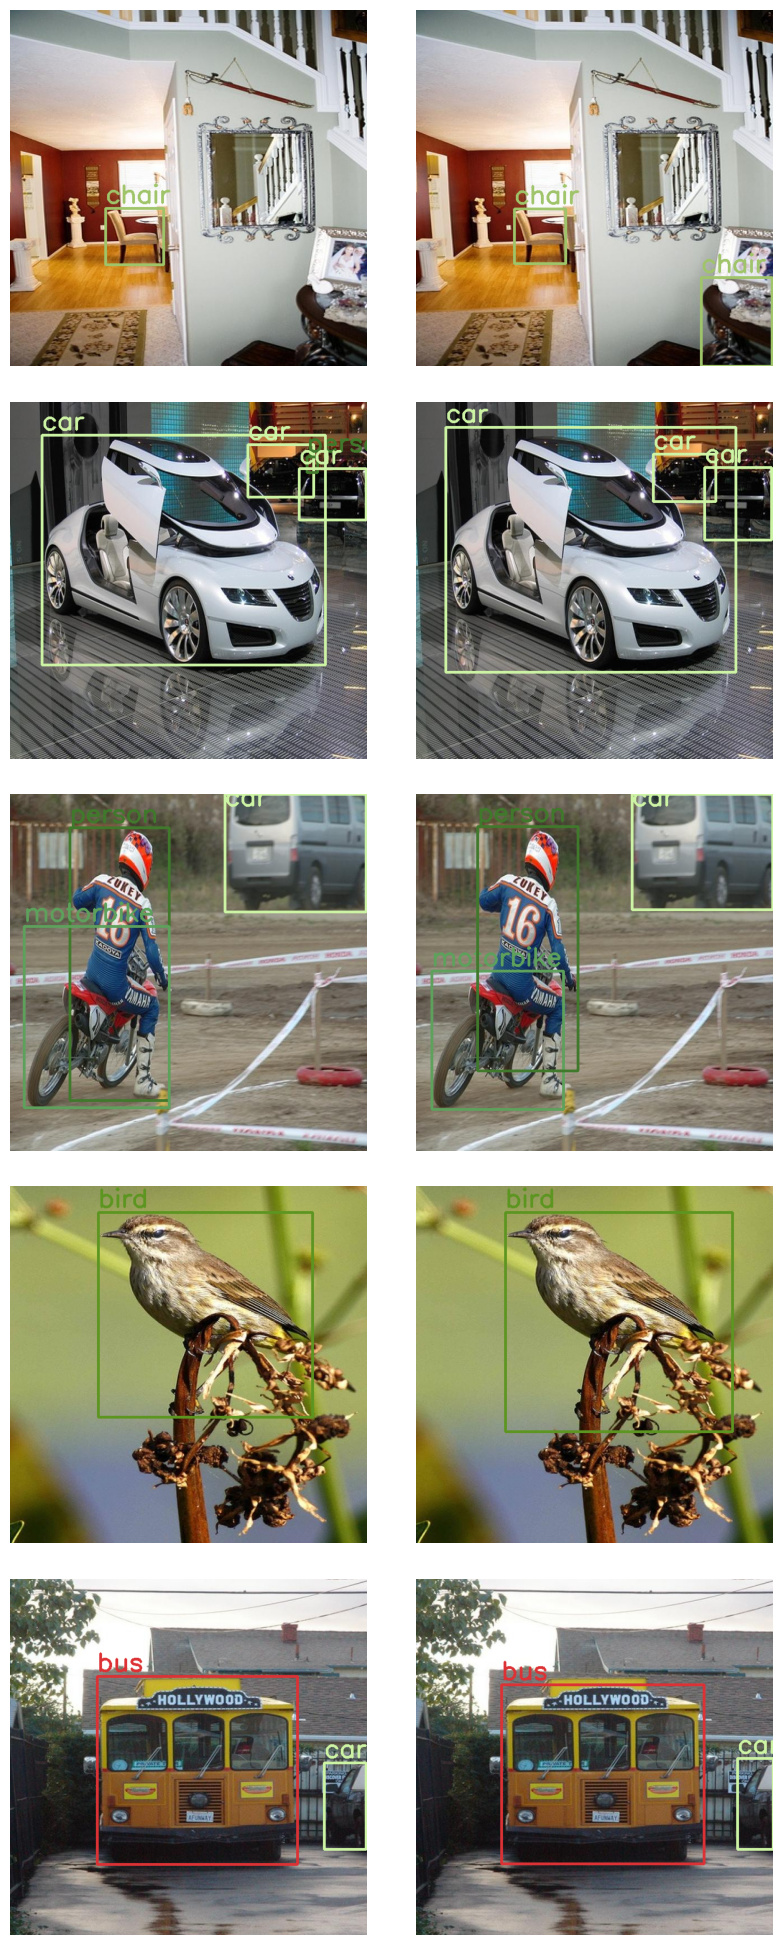

In [75]:
#The predicted and actual bounding boxes are plotted
fig,axes=plt.subplots(5,2,figsize=(10,25))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

test_img_list=list(sorted(os.listdir(test_imgs_dir)))
imgs_name=np.random.choice(test_img_list,5)

for i,img_name in enumerate(imgs_name):
    #ground truth - left column
    show_bbox(img_name,test_imgs_dir,test_labels_dir,axis=axes[i,0])
    
    #predicted label - right column
    show_bbox(img_name,test_imgs_dir,prediction_dir,axis=axes[i,1])
    
plt.savefig("2.png")

From the above images it can be seen that the models are able to detect the different objects in the image.